<b>Please install the following libraries to run this project:</b>

In [1]:
#pip install ipython-sql
#pip install mysqlclient
#pip install mysql-connector-python
#pip install pymysql
#pip install vaderSentiment
#pip install -U textblob

<b>Library Importation</b>

In [12]:
import numpy as np              
import pandas as pd             
import os
import shutil
import matplotlib.pyplot as plt

import mysql.connector
import pymysql

from pyspark.sql import SparkSession

# Load vaderSentimental library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Create and initialise an object
sentiment = SentimentIntensityAnalyzer()

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<b>Global Variables:</b>

In [15]:
# Path to data set
csv_file = "file:///home/hduser/Downloads/work2/ProjectTweets.csv"

In [42]:
# Parameters below will be used to beautify the graphs

# Define the graph style
plt.style.use("seaborn-Swhitegrid");

# define size and autolayout
# Autolayout: the graph will fit automaticaly on the screen resoltion
plt.rc("figure", autolayout=True, figsize=(11, 4));

# Defining axes atributes of the graph 
plt.rc(
    "axes",
    labelweight = "bold",
    labelsize = "large",
    titleweight = "bold",
    titlesize = 14,
    titlepad = 10,
);
# Defining axes atributes of the graph 
plot_params = dict(
    color = "0.75",
    style = ".-",
    markeredgecolor = "0.25",
    markerfacecolor = "0.25",
    legend = False,
);

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# format the graph as retina style
%config InlineBackend.figure_format = 'retina';

OSError: 'seaborn-Swhitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

# Data Understanding - Part 1

<b>Creating a new spark session and load CSV data to a temporary spark table and to a spark dataframe: </b>

In [16]:
#Import pyspark SQL
from pyspark.sql import SparkSession        

# Create a SparkSession
spark = (SparkSession
  .builder
  .appName("SparkSQL")
  .getOrCreate())

# Read and create a temporary view
# The dataset doesnt contain header, so header = false
# toDF to define appropriated column name
dfTwitter = (spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "false")
  .load(csv_file)
  .toDF('id', 'seq', 'date', 'query', 'user', 'tweet'))

dfTwitter.createOrReplaceTempView("tblTempTwitter")


<b>Printing some records to take a first look on the dataset:</b>

In [17]:
spark.sql("""SELECT * FROM tblTempTwitter""").show(10)

+---+----------+--------------------+--------+---------------+--------------------+
| id|       seq|                date|   query|           user|               tweet|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [18]:
spark.sql("""SELECT * FROM tblTempTwitter where query != 'NO_QUERY'""").show(10)

+---+---+----+-----+----+-----+
| id|seq|date|query|user|tweet|
+---+---+----+-----+----+-----+
+---+---+----+-----+----+-----+



In [19]:
spark.sql("""SELECT user, COUNT(user) as total FROM tblTempTwitter GROUP BY user ORDER BY total desc;""").show(20)



+---------------+-----+
|           user|total|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
|   SongoftheOss|  227|
|      Jayme1988|  225|
|         keza34|  219|
| ramdomthoughts|  216|
|      shanajaca|  213|
|         wowlew|  212|
|     nuttychris|  211|
|   TraceyHewins|  211|
|   thisgoeshere|  207|
|     Spidersamm|  205|
+---------------+-----+
only showing top 20 rows



Looking for null or blank date values

In [20]:
spark.sql("""SELECT user, tweet FROM tblTempTwitter where date is null or date =='';""").show(20)


+----+-----+
|user|tweet|
+----+-----+
+----+-----+



# Data Preparation

## SPARK HIVE

Creating a Database, table and proccessing data in Hive Metastore. 
<br/>
<b>Database name:</b> dbTwitter
<br/>
<b>Table name:</b> tblTwitter
<br/>
<b>Operation:</b> Store the CSV file in a permanent table in HIVE (Spark). This hive table will be used as a performance comparation with MySQL
<br/>


In [22]:
#Creating a Database dbTwitter in Hive
spark.sql("CREATE DATABASE IF NOT EXISTS dbTwitter")



2023-10-18 09:50:42,644 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-18 09:50:42,646 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-18 09:50:46,798 WARN metastore.ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
2023-10-18 09:50:46,798 WARN metastore.ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore hduser@127.0.1.1
2023-10-18 09:50:47,225 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
2023-10-18 09:50:47,242 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Database dbtwitter already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_database(HiveMetaStore.java:925)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeM

DataFrame[]

Using spark.sql() method "CREATE TABLE" to create a table in Hive from the spark temporary view tblTempTwitter.

In [23]:
#Create a Table in Hive tblTwitter on the bdTwitter database.
spark.sql("CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitter (id Int, seq Double, date String, query String, user String, tweet String)")



2023-10-18 09:50:55,618 WARN analysis.ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
2023-10-18 09:50:56,236 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2023-10-18 09:50:56,471 WARN conf.HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
2023-10-18 09:50:56,471 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-10-18 09:50:56,472 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-10-18 09:50:56,529 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Table tbltwitter already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_table_core(HiveMetaStore.java:1416)
	at org.apach

DataFrame[]

Inserting data from the spark temporary view tblTempTwitter into the Hive table tblTwitter:

In [29]:
#query to test if the table has rows, if has is because the code is been processed again and we do not need to reproccess
query = spark.sql("Select * from dbTwitter.tblTwitter LIMIT 1;")

#Test if the table is empty
if not query:
    #If the table is empty, them execute the code to fill with the dataset data
    #Insert into Hive tblTwitter using the spar temp view tblTempTwitter. 
    spark.sql("INSERT INTO TABLE dbTwitter.tblTwitter SELECT * FROM tblTempTwitter")    
else:
    print("Table is not empty!")


Table is not empty!


In [26]:
#Lets view the data in the hive table
spark.sql("SELECT * FROM dbTwitter.tblTwitter").show(10)

+------+-------------+--------------------+--------+---------------+--------------------+
|    id|          seq|                date|   query|           user|               tweet|
+------+-------------+--------------------+--------+---------------+--------------------+
|545133|2.201337104E9|Tue Jun 16 20:08:...|NO_QUERY|      alt_ducky|@miss_clariss oh ...|
|545134|2.201337108E9|Tue Jun 16 20:08:...|NO_QUERY|     CourtneyVR|Failed my WOF. Wi...|
|545135|2.201337287E9|Tue Jun 16 20:08:...|NO_QUERY|    melissaholt|Watching the firs...|
|545136|2.201337425E9|Tue Jun 16 20:08:...|NO_QUERY|       itznesha|my computer is in...|
|545137|2.201337512E9|Tue Jun 16 20:08:...|NO_QUERY|    lovinmyboys|Worked out my upp...|
|545138|2.201337757E9|Tue Jun 16 20:08:...|NO_QUERY|     mikerbrant|OMG I got my new ...|
|545139|2.201338077E9|Tue Jun 16 20:08:...|NO_QUERY|         daulex|my back has flare...|
|545140|2.201338113E9|Tue Jun 16 20:08:...|NO_QUERY|    CaliHeather|I am starting to ...|
|545141|2.

## MySQL

Creating a Database, tables and proccess data with MySQL
<br/>
<b>Database name:</b> dbTwitter
<br/>
<b>Table names:</b> tblTwitter, tblTwitterPrep
<br/>
<b>Details:</b> 
<br/>
MySQL is used to do the Data Preparation in this project.
<br/>
New tables were created, new features, data transformation, and all necessary steps to prepare the data to be fit on the forecast model.

Please intall the my sql connector version 8.1.0

<b>PLEASE, RUN THE COMMANDS BELOW ON TERMINAL TO CREATE AND GRANT PERMISSIONS TO user1:</b>
<br/>
<br/>
mysql -u root -p
<br/>
CREATE USER 'user1'@'%%' IDENTIFIED BY 'Pass@word1';
<br/>
GRANT ALL PRIVILEGES ON * . * TO 'Pass@word1'@'%%';
<br/>
FLUSH PRIVILEGES;
<br/>

<b>Configuring a new connection to the localhost Mysql server:</b>

In [3]:
# Creating a connection to the mySQL database 
connMySQL = pymysql.connect(host = 'localhost',
                             user = 'user1',
                             password = 'Pass@word1',
                             db = 'dbTwitter')

cursor = connMySQL.cursor()

<b>Creating a new database and the first table on MySQL:</b>

In [32]:

#Creating a new database if not exists
cursor.execute("CREATE DATABASE IF NOT EXISTS dbTwitter;")
#Use the dbTwitter in the context
cursor.execute("USE dbTwitter;")

#Creating a new table if not exists
cursor.execute("CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitter (id NUMERIC, seq NUMERIC, date VARCHAR(50), query VARCHAR(50), user VARCHAR(50), tweet TEXT)")

0

<b>Copy the data from Hive table to the correspondent table in MySQL: </b>

In [13]:
#COPY the data from HIVE table to My SQL table

query = connMySQL.query('SELECT id FROM dbTwitter.tblTwitter LIMIT 1;')

#Test if the table is empty
if not query:
    # convert the spark dataframe to pandas dataframe to iterate 
    dfPandasTwitter = dfTwitter.toPandas()
    
    #If the table is empty, them execute the code to fill with the dataset data
    # reading the columns to use on the insert clause
    cols = ",".join([str(i) for i in dfPandasTwitter.columns.tolist()])

    # Insert on the mySQL table all records from SPark SQL
    for i, row in dfPandasTwitter.iterrows():
        sql = "INSERT INTO tblTwitter (" + cols + ") VALUES (" + "%s," * (len(row) - 1) + "%s)"
        cursor.execute(sql, tuple(row))
        
        # the connection is not autocommitted by default, so commit command is necessary to save the changes
        connMySQL.commit()
else:
    print ("This table is not empty!")



This table is not empty!


<b>Creating a new table with the new necessary features:</b>
<br/>
<br/>
The idea is keeping the original table to be used in the performance comparision, all the data preparation will be processed in this new table.
<br/>
<br/>
<b>New features:</b>
<li>date_custom: Date</li>
<li>week: Char(3)</li>
<li>hour: Int</li>
<li>minute: Int</li>
<li>second: Int</li>
<li>day: Int</li>
<li>month: Int</li>
<li>year: Int</li>
<li>sentiment: Double</li>

In [4]:
# Creating the new table to start the data preparation
# It was excluded 
cursor.execute("""CREATE TABLE IF NOT EXISTS dbTwitter.tblTwitterPreparation (
                id Int, 
                date VARCHAR(50), 
                user VARCHAR(50),                 
                tweet TEXT, 
                tweet_review TEXT, 
                date_custom Date,
                week CHAR(3), 
                hour Int, 
                minute Int, 
                second Int, 
                day Int, 
                month Int, 
                year Int, 
                sentiment_vader Double,
                sentiment_blob Double,
                INDEX (id))
              """)

connMySQL.commit()

In [5]:

#cursor.execute("DROP TABLE dbTwitter.tblTwitterPrep;")
#connMySQL.commit()

<b>Inserting data to the Data Preparation table (tblTwitterPrep) transforming data during the proccess:</b>
<br/>
<br/>
Substring function is used to split the original date value to separeted columns like day, year, hour... These columns can be usefull to plot graphs or to fit in the Machine Learning models.
<br/>
Switch case is used to transform the text value of month (apr, may, jun) into a number value (4, 5 ,6).
<br/>
a DD/MM/YYYY will be processed after this step.
<br/>
<br/>
<b>Original date format:</b> Mon Apr 06 22:19:45 PDT 2009	
<br/>
.

In [7]:
query = connMySQL.query('SELECT id FROM dbTwitter.tblTwitterPreparation LIMIT 1;')

#Test if the table is empty
if not query:
    #If the table is empty, them execute the code to fill with the dataset data    
    
    cursor.execute("""INSERT INTO dbTwitter.tblTwitterPreparation 
                  (id, date, user, tweet, 
                  tweet_review, date_custom, 
                  week, hour, minute, second, 
                  day, month, year, sentiment_vader, sentiment_blob)
                  SELECT id, 
                  date, 
                  user, 
                  tweet,
                  NULL,
                  NULL,
                  SUBSTR(date, 1, 3), 
                  SUBSTR(date, 12, 2), 
                  SUBSTR(date, 15, 2),                    
                  SUBSTR(date, 18, 2),                                      
                  SUBSTR(date, 9, 2),                                                        
                  CASE SUBSTR(date, 5, 3)                      
                      WHEN 'apr' THEN 4
                      WHEN 'may' THEN 5
                      WHEN 'jun' THEN 6                      
                      ELSE NULL
                  END,   
                  SUBSTR(date, 25, 4),                                                                          
                  0.0,  
                  0.0
                  FROM dbTwitter.tblTwitter;""")   
    
    connMySQL.commit()
    
else:
    print("Table is not empty!")



<b>Creating a YYYY/MM/DD date value:</b>

In [4]:

sql = """UPDATE dbTwitter.tblTwitterPreparation t1, dbTwitter.tblTwitterPreparation t2 
SET t1.date_custom = STR_TO_DATE( 
         CONCAT( t2.day, '/', t2.month, '/', t2.year ), '%d/%m/%Y')
WHERE t1.id = t2.id"""

cursor.execute(sql)

connMySQL.commit()

 - a positive sentiment, compound ≥ 0.05.
 - a negative sentiment, compound ≤ -0.05.
 - a neutral sentiment, the compound is between ]-0.05, 0.05[


In [ ]:

#df_Sentimental_Analysis.at[i,'compound'] = sent['compound']
#if float(sent['compound']) >= 0.05:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'positive'
#    positive += 1
#elif float(sent['compound']) <= -0.05:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'negative'
#    negative += 1
#else:
#    df_Sentimental_Analysis.at[i,'sentiment'] = 'neutral'
#    neutral += 1

#### Calculating the sentiment (Vader and Blob)

Each tweet will have the text sentiment calculated using VADER and Blob.
<br/>
This is an step to prepare the data for forecasting.
<br/>
<br/>
<b><span style="color:red">I strongly do not recommend </span>to run the vader calculation step below. Even using index to tunning the table, this step took more than one hour to be processed. Instead you can restore the database backup submitted.



In [24]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

stop = stopwords.words('english')

In [26]:
print(get_text_processing("This bad, is a: test; for' the stop wonderful words function, try again, the a an if this those work!"))

bad test stop wonderful words function try work


In [18]:
testimonial = TextBlob(get_text_processing("This bad is a test for the stop wonderful words function, try again, the a an if this those work!"))
print(testimonial.sentiment)
print(testimonial.sentiment[0])

Sentiment(polarity=0.15000000000000008, subjectivity=0.8333333333333333)
0.15000000000000008


In [ ]:
#Loading all the rows to be proccessed with the sentiment
dfTweets = pd.read_sql(sql = "select id, tweet from dbTwitter.tblTwitterPreparation", con = connMySQL)


In [29]:
#Loading all the rows to be proccessed with the sentiment
#dfTweets = pd.read_sql(sql = "select id, tweet from dbTwitter.tblTwitterPreparation", con = connMySQL)

#Iterate on the dataset to calculate the sentiment of each tweet and store on the database
for i, row in dfTweets.iterrows():

    tweet_reviewed = get_text_processing(row["tweet"])
    #tweet_reviewed = tweet_reviewed.replace("'", "")
    #tweet_reviewed = tweet_reviewed.replace('"', '')
        
    print("tweet_reviewed: " + tweet_reviewed)
        
    #Calculate the sentiment
    sent_vader = sentiment.polarity_scores(tweet_reviewed)['compound']
    sent_blob = TextBlob(tweet_reviewed).sentiment[0]
    
    sql = "UPDATE dbTwitter.tblTwitterPrep SET "
    sql += "sentiment_vader = " + str(sent_vader) + ", "
    sql += "sentiment_blob = " + str(sent_blob) + ", "
    sql += "tweet_review = '" + str(tweet_reviewed) + "' "
    sql += " WHERE id = " + str(row["id"]) + ";"
    
    print("sql: " + sql)
    
    print("id: " + str(row["id"]))

    cursor.execute(sql)    
    # the connection is not autocommitted by default, so commit command is necessary to save the changes
    connMySQL.commit()
    
    break

    

tweet_reviewed: switchfoot httptwitpiccom2y1zl Awww thats bummer shoulda got David Carr Third Day
sql: UPDATE dbTwitter.tblTwitterPrep SET sentiment_vader = -0.3818, sentiment_blob = 0.2, tweet_review = 'switchfoot httptwitpiccom2y1zl Awww thats bummer shoulda got David Carr Third Day'  WHERE id = 0;
id: 0


KeyboardInterrupt: 

# Data Understanding - Part 2

Having the original date value splitted in different columns will allow to performing better analysis on the data quality.
<br/>
Group by clauses are now possible (or at least easier) to be performed and some analysis can be prepared, like:
<li>Searching for missing tweets per day</li>
<li>Searching for missing tweets per hour</li>
<li>Analysing the weight difference between days/months</li>

In [61]:
sql = """SELECT date_custom as date, AVG(sentiment) as sentiment
FROM dbTwitter.tblTwitterPreparation
GROUP BY date_custom
ORDER BY date_custom"""

dfTweetsPredict = pd.read_sql(sql = sql, con = connMySQL)

sql2 = """SELECT DATE(date_custom) as date, AVG(sentiment) as sentiment
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment != 0
GROUP BY date_custom
ORDER BY date_custom"""

dfTweetsPredict2 = pd.read_sql(sql = sql2, con = connMySQL)


In [63]:

dfTweetsPredict

,date,sentiment
0,2009-04-06,0.151224
1,2009-04-07,0.166838
2,2009-04-17,0.204035
3,2009-04-18,0.185487
4,2009-04-19,0.187174
5,2009-04-20,0.177421
6,2009-04-21,0.179456
7,2009-05-01,0.179711
8,2009-05-02,0.184041
9,2009-05-03,0.176675


<Figure size 1100x400 with 0 Axes>

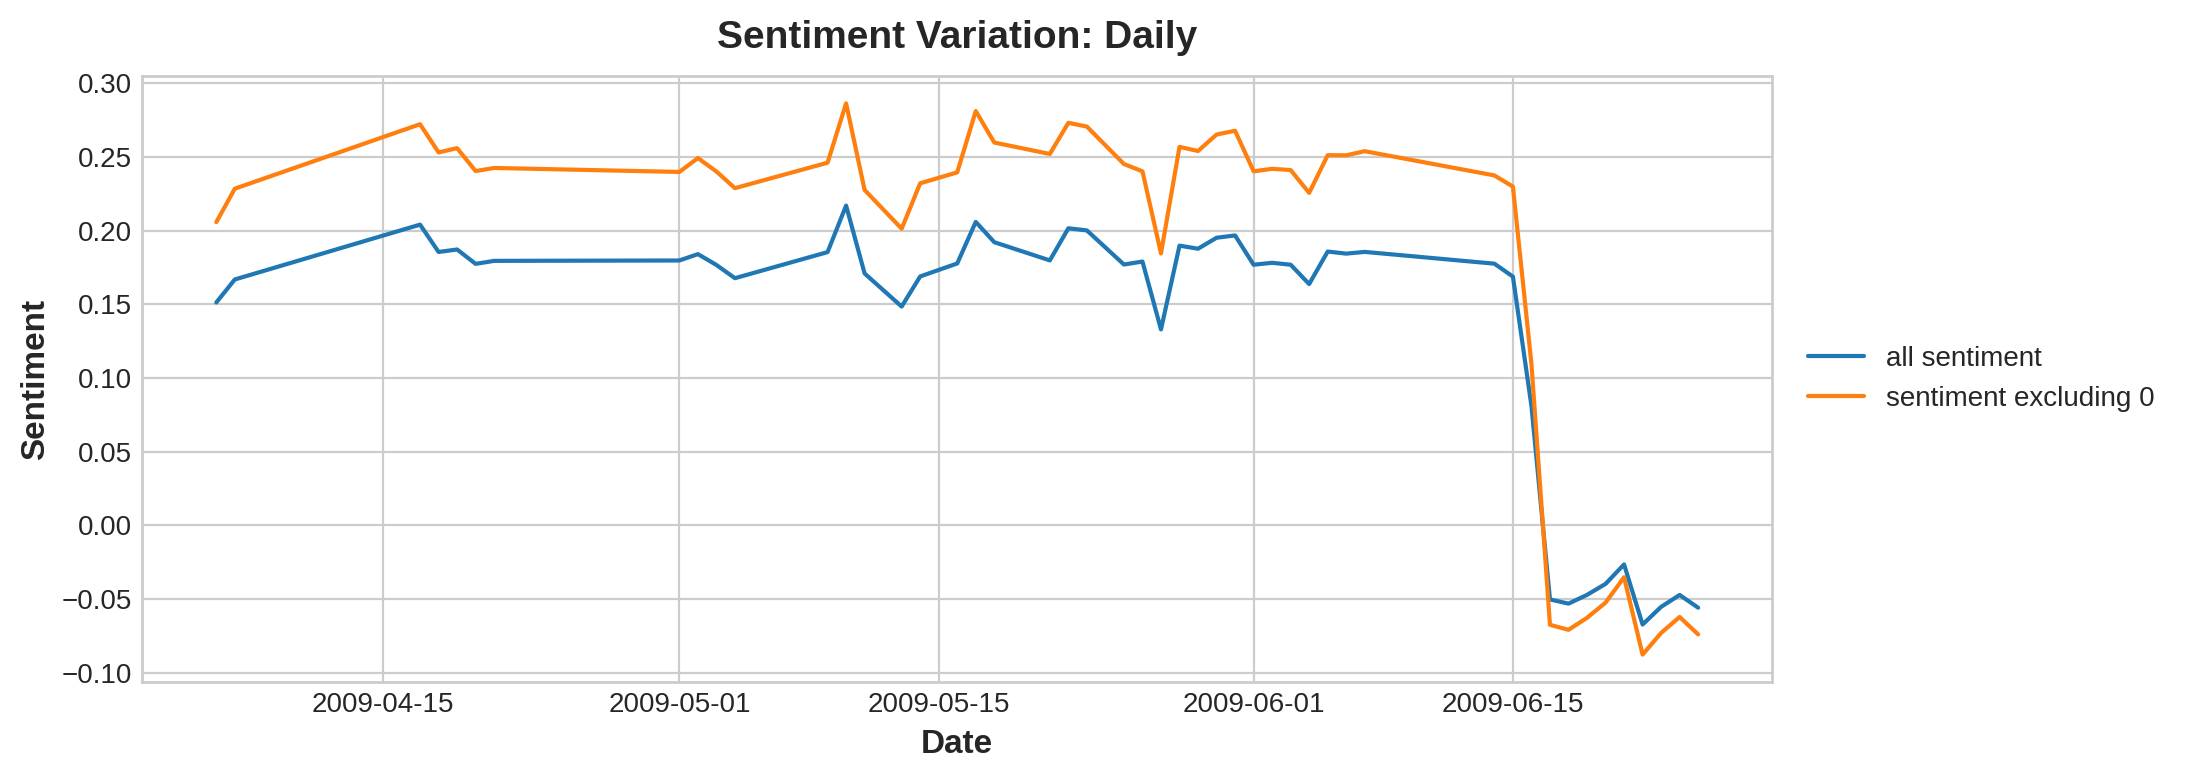

In [62]:
# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict['date'], dfTweetsPredict['sentiment'], label='all sentiment');  # Plot first line of data.
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment'], label='sentiment excluding 0');  # Plot second line of data

ax.set_xlabel('Date');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend

In [59]:
sql = """SELECT concat(year, month, day, hour) as date, AVG(sentiment) as sentiment
FROM dbTwitter.tblTwitterPreparation
GROUP BY concat(year, month, day, hour)"""

dfTweetsPredict = pd.read_sql(sql = sql, con = connMySQL)

sql2 = """SELECT concat(year, month, day, hour) as date, AVG(sentiment) as sentiment
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment != 0
GROUP BY concat(year, month, day, hour)"""

dfTweetsPredict2 = pd.read_sql(sql = sql2, con = connMySQL)

<Figure size 1100x400 with 0 Axes>

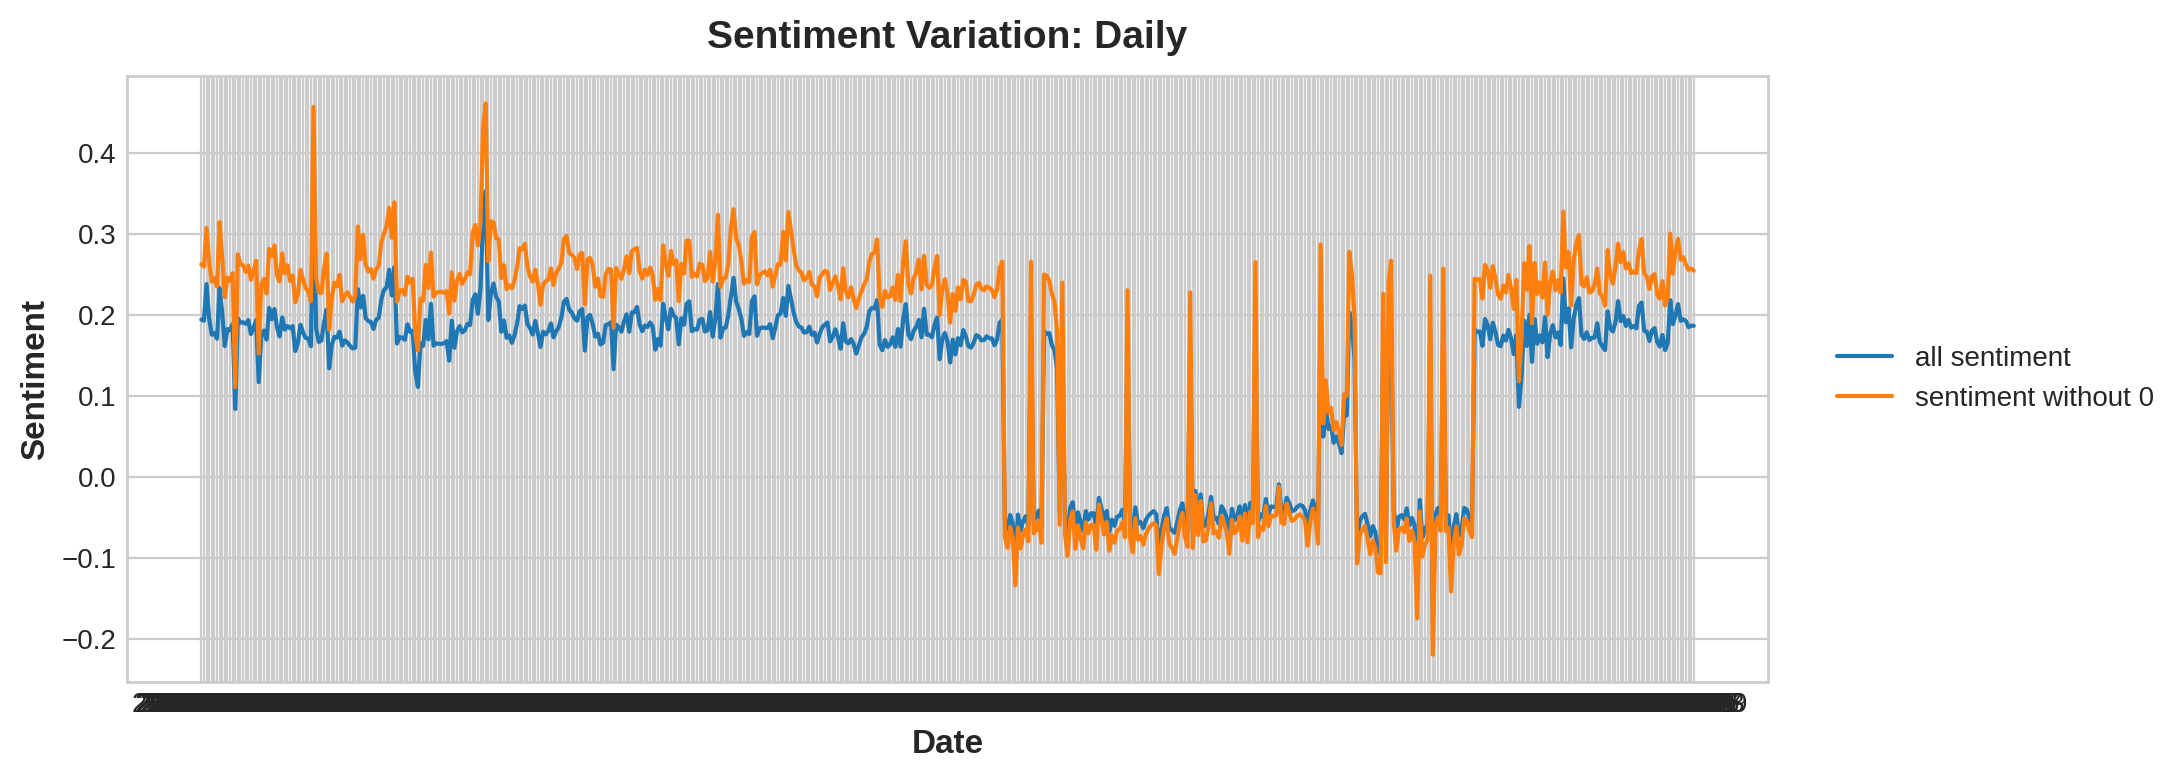

In [60]:

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict['date'], dfTweetsPredict['sentiment'], label='all sentiment');  # Plot first line of data.
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment'], label='sentiment without 0');  # Plot second line of data

ax.set_xlabel('Date Hour');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend

In [70]:
sql = """SELECT week as date, AVG(sentiment) as sentiment
FROM dbTwitter.tblTwitterPreparation
GROUP BY week"""

dfTweetsPredict = pd.read_sql(sql = sql, con = connMySQL)

sql2 = """SELECT week as date, AVG(sentiment) as sentiment
FROM dbTwitter.tblTwitterPreparation
WHERE sentiment != 0
GROUP BY week"""

dfTweetsPredict2 = pd.read_sql(sql = sql2, con = connMySQL)

In [ ]:
dfTweetsPredict2

<Figure size 1100x400 with 0 Axes>

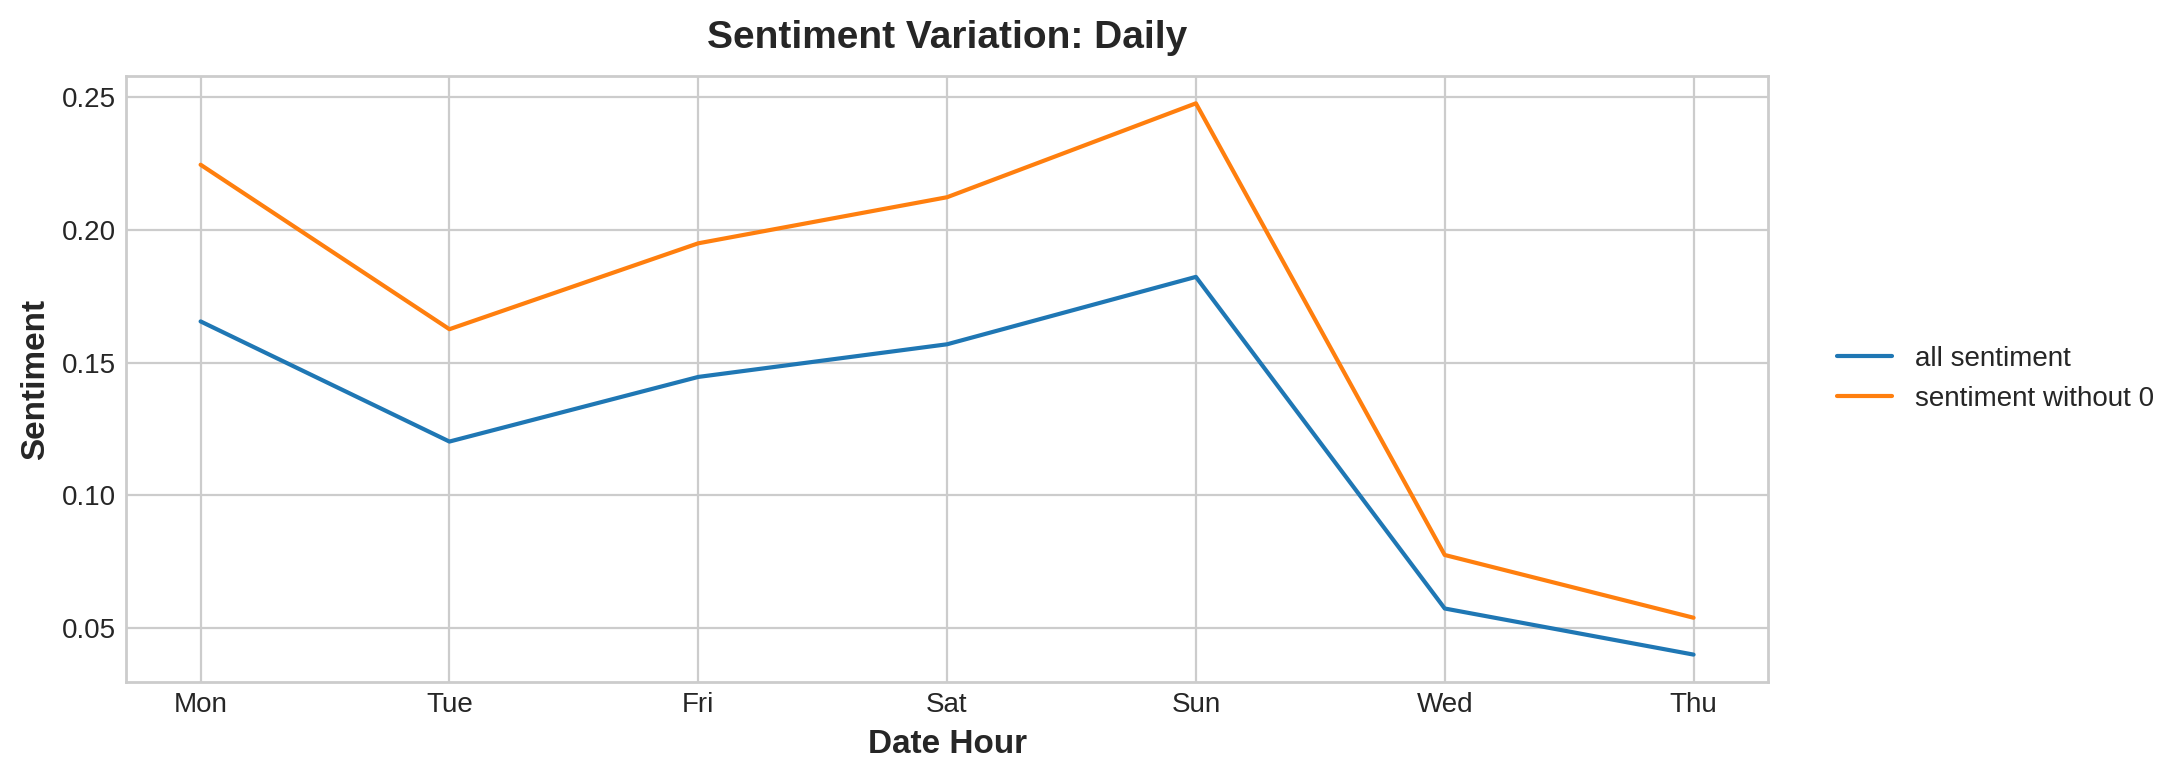

In [71]:

# Command to autoformat date axis
plt.gcf().autofmt_xdate();

# create figure and axis objects with subplots()
fig, ax = plt.subplots();

# Ploting graph lines
ax.plot(dfTweetsPredict['date'], dfTweetsPredict['sentiment'], label='all sentiment');  # Plot first line of data.
ax.plot(dfTweetsPredict2['date'], dfTweetsPredict2['sentiment'], label='sentiment without 0');  # Plot second line of data

ax.set_xlabel('Date Hour');  # Add an x-label to the axes.
ax.set_ylabel('Sentiment');  # Add a y-label to the axes.

ax.set_title("Sentiment Variation: Daily");  # Add a title to the graph.
ax.legend(loc="right", bbox_to_anchor=(1.25, 0.5)) #Better positioning the legend